# **Deep Learning Homework 5: *Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti & Prof. Nicolò Navarin and Dr. Luca Pasa
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Finally, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder).

#Requirements

In [ ]:
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━

#Imports

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

# Data Loading

We load the `CIFAR-10 dataset`, available from `torchvision.datasets`. This dataset is one of the most popular benckmark in the filed of Computer Vision. It consits of $10$ different classes, that represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The dataset contains $50,000$ training images and $10,000$ images for testing.

First, we will pre-process them with a `PreProcessing` fuction that works in the following way. The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between $0$ and $255$, and it represents a point of an image of size $32\times32$. We will normalize all values between $0$ and $1$, and we will flatten the $32\times32$ images into vectors of size $1024$.
Moreover, since no validation set is defined, we split the train set in a validation set and a new test set.
Finally, we design a custom dataset class, derived from the standard `Dataset` class, that returns a PyTorch Dataset object, along with its noisy version. The Gaussian noise is tunable with the `noise_factor` parameter and will be used for the Denoising Autoencoder.

In [ ]:
to_tensor = transforms.ToTensor()

def PreProcessing(img):
  img = to_tensor(img) #PIL to tensor + Scaling
  img = torch.mean(img, 0) #One channel averaged over the colors
  img = img.reshape(torch.prod(torch.tensor(img.shape))) #Flattening
  return img.to(torch.float32)

In [ ]:
dataset = CIFAR10(root='data/', download=True, train=True, transform=transforms.Lambda(PreProcessing)) # 50000 samples
test_data = CIFAR10(root='data/', download=True, train=False, transform=transforms.Lambda(PreProcessing)) # 10000 samples

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [ ]:
val_size = 10000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 40000 
Validation samples = 10000 
Test samples = 10000


In [ ]:
class CustomDataset(Dataset):
  def __init__(self, dataset, noise_factor, device='cpu'):
    super().__init__()
    self.dataset = dataset
    self.nf = noise_factor
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    x, _ = self.dataset[idx]
    x_noisy = x + self.nf*np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    x_noisy = np.clip(x_noisy, 0., 1.).to(torch.float32)
    return (x.to(device), x_noisy.to(device))

In [ ]:
# Set noise factor for later
noise_factor = 0.1

# [TO COMPLETE] SVD

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linearly combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices, $V$ and $U$, and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in PyTorch as `torch.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [ ]:
def svd_k(X, k):
  # k: sets the number of components to keep

  # Compute the matrix C
  C = torch.matmul(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = torch.linalg.svd(C)
  # Limit the number columns of U to k
  U_k = U[:,:k]
  return U_k

Now we create the dataset ready for the SVD:

In [ ]:
device = torch.device("cpu") #for SVD

x_train, x_train_noisy = next(iter(DataLoader(CustomDataset(train_data, noise_factor, device), batch_size=len(train_data))))
x_val, x_val_noisy = next(iter(DataLoader(CustomDataset(val_data, noise_factor, device), batch_size=len(val_data))))
x_test, x_test_noisy = next(iter(DataLoader(CustomDataset(test_data, noise_factor, device), batch_size=len(test_data))))

x_train.shape, x_train_noisy.shape, x_val.shape, x_val_noisy.shape, x_test.shape, x_test_noisy.shape

(torch.Size([40000, 1024]),
 torch.Size([40000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]))

Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and test set.


In [ ]:
ENCODING_DIM = 256 #[TO COMPLETE]

U_k = svd_k(x_train, ENCODING_DIM)

x_training_svd = torch.matmul(x_train, U_k)
x_test_svd = torch.matmul(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [ ]:
x_training_reco = torch.matmul(x_training_svd, U_k.T)
x_test_reco = torch.matmul(x_test_svd, U_k.T)

In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00150
Test mse: 0.00153


In [ ]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

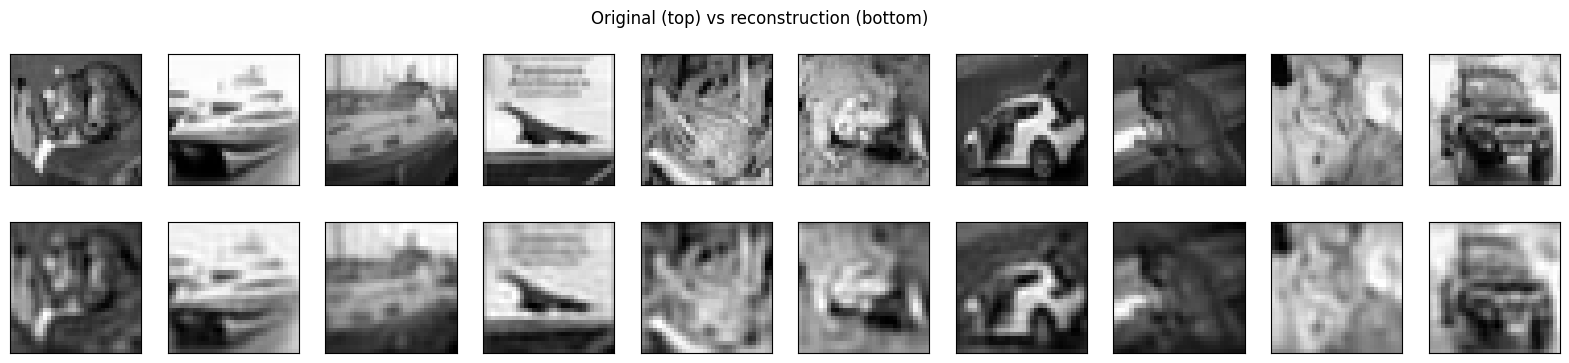

In [ ]:
_ = plot_img(10, [x_test, x_test_reco], title="Original (top) vs reconstruction (bottom)")


**[TO COMPLETE]**: What happens by varying the ENCODING_DIM?
 Test and discuss the results in a cell below.

`%STARTEXT`

**ANSWER**:

Decreasing the value ENCODING_DIM both the training and test loss increase, and the final reconstructed images become more blurred. However, the model seems to be enough precise in the image reconstruction.

`%ENDEXT`

# [TO COMPLETE] Shallow Linear Autoencoder

Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. First, we define the `DataLoader` to train the model.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512
noise_factor = 0.1 # adjust the noise level here.

dataloader_train_AE = DataLoader(CustomDataset(train_data, noise_factor, device), batch_size = batch_size)
dataloader_val_AE = DataLoader(CustomDataset(val_data, noise_factor, device), batch_size = batch_size)
dataloader_test_AE = DataLoader(CustomDataset(test_data, noise_factor, device), batch_size = batch_size)

Then, we build our shallow Autoencoder. Here's a breakdown of the code to help you grasp how it works:

1. The `__init__` method is the initialization function for the Auto_Encoder class. It takes four parameters: `input_dim` (dimensionality of the input data), `enc_layers` (a list specifying the sizes of the encoder layers), `dec_layers` (a list specifying the sizes of the decoder layers), and `act_fun` (the activation function to be used).

2. The `nn.ModuleList()` is used to create empty lists E_layers and D_layers to store the encoder and decoder layers, respectively.

3. The `for loop `iterates over the `enc_layers` list to create the encoder layers. For the first layer, it creates a linear layer (`nn.Linear`) mapping from the input dimension to the size of the first encoder layer. For subsequent layers, it creates linear layers mapping between consecutive encoder layer sizes. The created layers are appended to the `self.E_layers` list.

4. The code then checks if the `dec_layers` list is empty. If it is empty, it creates a single linear layer mapping from the last encoder layer size to the input dimension (remember: the goal of the AE is to reconstruct the input). Otherwise, it iterates over the `dec_layers` list to create the decoder layers, similar to how the encoder layers were created. The last decoder layer is always mapped to the input dimension.

5. The `_init_weights` method is a helper function that initializes the weights of the linear layers. It is applied to all modules (layers) of the Auto_Encoder instance.

6. The `forward` method defines the forward pass of the Autoencoder.

In [ ]:
class Auto_Encoder(nn.Module):

  def __init__(self, input_dim, enc_layers, dec_layers, act_fun):
    super().__init__()

    self.E_layers = nn.ModuleList()
    self.D_layers = nn.ModuleList()
    self.act_fun = act_fun
    activation_functions = {'linear': transforms.Lambda(lambda x: x),
                            'sigmoid': F.sigmoid,
                            'relu': F.relu,
                            'tanh': F.tanh,
                            'leaky_relu': F.leaky_relu}
    assert self.act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
    self.af = activation_functions[self.act_fun]

    for layer_idx in range(len(enc_layers)):
      if layer_idx == 0:  # first layer, from input to enc
        self.E_layers = self.E_layers.append(nn.Linear(input_dim, enc_layers[layer_idx]))
      else:  # hidden layers, depending on the input
        self.E_layers = self.E_layers.append(nn.Linear(enc_layers[layer_idx-1], enc_layers[layer_idx]))

    if len(dec_layers) == 0:
      self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], input_dim))
    else:
      for layer_idx in range(len(dec_layers)):
        if layer_idx == 0:  # first layer, from enc to dec
          self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], dec_layers[layer_idx]))
        else:  # hidden layers, depending on the input
          self.D_layers = self.D_layers.append(nn.Linear(dec_layers[layer_idx-1], dec_layers[layer_idx]))

      self.D_layers = self.D_layers.append(nn.Linear(dec_layers[-1], input_dim)) # final output layer

    self.apply(self._init_weights)

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=.1)
        if module.bias is not None:
            module.bias.data.zero_()

  def forward(self, x):
    for layer in self.E_layers:
      x = self.af(layer(x))
    for layer in self.D_layers[:-1]:
      x = self.af(layer(x))
    if self.act_fun == 'linear':
      return self.D_layers[-1](x)
    else:
      return F.sigmoid(self.D_layers[-1](x)) #last act func is always sigmoid

**[TO COMPLETE]** Check the results and compare them with the ones obtained with the SVD. In the cell at the end of this section (after the result of the linear autoencoder), give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.

Try also to be aquainted with the usual PyTorch training and evaluation routines. In the following part of the HW, the more training epochs the better the resutls, but it will also take longer. Feel free to change the `epochs` variable, just be consistent to make fair comparisons.

In [ ]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256]
DEC_LAYERS = []
ACT_FUN = 'linear'
lr = 0.005
epochs = 30 # Feel free to lower this to speed up the training times. Nevertheless, do not go below 25 epochs.

Shallow_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_AE.parameters(), lr=lr)

In [ ]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs, denoising=False):
  loss_train, loss_val = [], []
  for epoch in range(epochs):

    model.train()
    total_count_train, n_train_batches, total_loss_train = 0, 0, 0
    for idx, (x, x_noisy) in enumerate(dataloader_train):
      optimizer.zero_grad()
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss = criterion(x_rec, x)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_count_train += x.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())

    total_count_val, n_val_batches, total_loss_val = 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (x, x_noisy) in enumerate(dataloader_val):
            if denoising:
              x_rec = model(x_noisy)
            else:
              x_rec = model(x)

            loss = criterion(x_rec, x)
            total_loss_val += loss
            total_count_val += x.size(0)
            n_val_batches += 1

    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: Val_Loss: {avg_loss_val:.8f}")
  return loss_train, loss_val

In [ ]:
start = timer()
loss_train, loss_val = train(Shallow_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.85132295 ---------------- Val_Acc: Val_Loss: 0.24235280
epoch: 2 -> Loss: 0.18435420 ---------------- Val_Acc: Val_Loss: 0.14430505
epoch: 3 -> Loss: 0.11869568 ---------------- Val_Acc: Val_Loss: 0.09985980
epoch: 4 -> Loss: 0.08741672 ---------------- Val_Acc: Val_Loss: 0.07662451
epoch: 5 -> Loss: 0.06505850 ---------------- Val_Acc: Val_Loss: 0.05882430
epoch: 6 -> Loss: 0.05227219 ---------------- Val_Acc: Val_Loss: 0.05610590
epoch: 7 -> Loss: 0.04484684 ---------------- Val_Acc: Val_Loss: 0.03967278
epoch: 8 -> Loss: 0.03574723 ---------------- Val_Acc: Val_Loss: 0.03335504
epoch: 9 -> Loss: 0.03041309 ---------------- Val_Acc: Val_Loss: 0.02884416
epoch: 10 -> Loss: 0.02644971 ---------------- Val_Acc: Val_Loss: 0.02548597
epoch: 11 -> Loss: 0.02329162 ---------------- Val_Acc: Val_Loss: 0.02254615
epoch: 12 -> Loss: 0.02082497 ---------------- Val_Acc: Val_Loss: 0.02311639
epoch: 13 -> Loss: 0.01966192 ---------------- Val_Acc: Val_Loss: 0.01837760
epoch: 1

In [ ]:
def plot_learning_acc_and_loss(loss_tr, loss_val):
    info = {'loss_training':loss_tr, 'loss_validation':loss_val}
    df = pd.DataFrame(info)
    df.plot(figsize=(10, 8), subplots=[('loss_training','loss_validation')], grid=True)
    plt.xlabel("Epochs")
    plt.show()

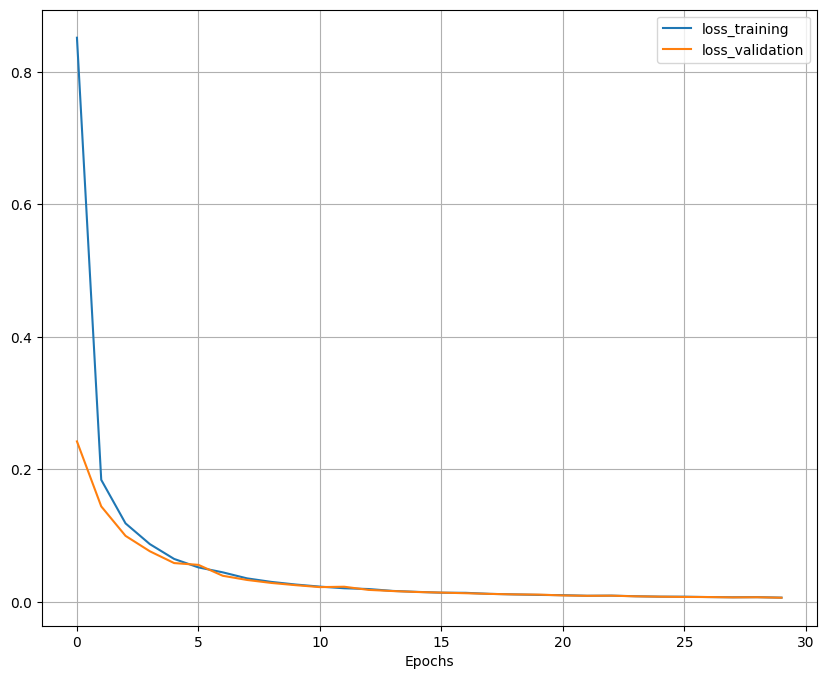

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
def test(model, dataloader_test=dataloader_test_AE, denoising=False): #dataloader_test_AE not train
  model.eval()
  total_count_test, n_batches_test, loss = 0, 0, 0
  for idx, (x, x_noisy) in enumerate(dataloader_test):
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss += criterion(x_rec, x)
      total_count_test += x.size(0)
      n_batches_test += 1
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}")

In [ ]:
test(Shallow_AE)

Test Loss: 0.00651115


In [ ]:
@torch.no_grad()
def apply_on_test(model, device, denoising=False):
  if denoising:
    x = x_test_noisy.to(device)
  else:
    x = x_test.to(device)
  for layer in model.E_layers:
      x = model.af(layer(x))
  encoded_imgs = x


  y = encoded_imgs
  for layer in model.D_layers[:-1]:
      y = model.af(layer(y))
  if model.act_fun == 'linear':
    decoded_imgs = model.D_layers[-1](y)
  else:
    decoded_imgs = F.sigmoid(model.D_layers[-1](y))

  return (encoded_imgs.to("cpu"), decoded_imgs.to("cpu"))

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_AE, device=device)

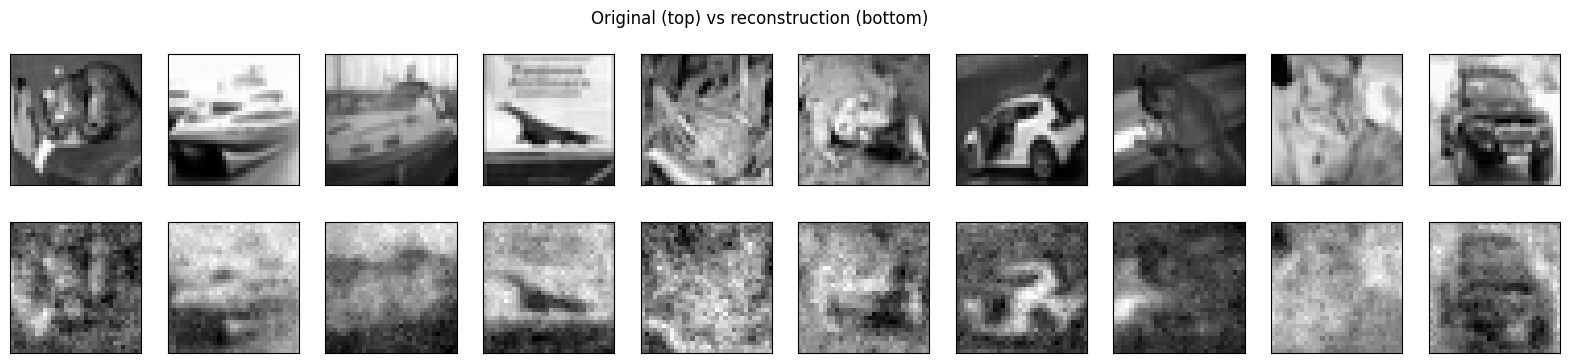

In [ ]:
plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

Comment the results obtained with the shallow linear autoencoder in relation to the ones obtained by the SVD decomposition. Are they different or similar? Why do you think they are so? (hint: consider the theoretical relationship between SVD and a shallow linear autoencoder.)

`%STARTEXT`

**ANSWER**:

The shallow linear autoencoder perform a test loss of 0.00651. The images reconstructed by the autoencoder result very noisy, and very different from the SVD model reconstructued images. The SVD method does not require any training and computes directly the image reconstruction. The noise produced by the autoencoder instead is maybe because of the considered model is too shallow, and a relatively big amount of information is lost during the encoding of the hidden representation.

`%ENDTEXT`

# [TO COMPLETE] Shallow non-linear Autoencoder

**[TO COMPLETE]** Replicate the code of the previous exercise but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice in the last cell of this section. Discuss the results you obtained in relation to those obtained with the Shallow Linear Autoencoder.

`%STARTCODE`

In [ ]:
# [TO COMPLETE]
# define model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256]
DEC_LAYERS = []
ACT_FUN = 'sigmoid'
lr = 0.005
epochs = 30
# END

Shallow_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_non_AE.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, loss_val = train(Shallow_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.04083422 ---------------- Val_Acc: Val_Loss: 0.02895239
epoch: 2 -> Loss: 0.02249319 ---------------- Val_Acc: Val_Loss: 0.01894928
epoch: 3 -> Loss: 0.01794497 ---------------- Val_Acc: Val_Loss: 0.01560938
epoch: 4 -> Loss: 0.01589433 ---------------- Val_Acc: Val_Loss: 0.01385975
epoch: 5 -> Loss: 0.01403169 ---------------- Val_Acc: Val_Loss: 0.01273908
epoch: 6 -> Loss: 0.01207733 ---------------- Val_Acc: Val_Loss: 0.01615759
epoch: 7 -> Loss: 0.01170069 ---------------- Val_Acc: Val_Loss: 0.01129743
epoch: 8 -> Loss: 0.01063429 ---------------- Val_Acc: Val_Loss: 0.01091593
epoch: 9 -> Loss: 0.01010797 ---------------- Val_Acc: Val_Loss: 0.00985731
epoch: 10 -> Loss: 0.00955640 ---------------- Val_Acc: Val_Loss: 0.00973557
epoch: 11 -> Loss: 0.00920809 ---------------- Val_Acc: Val_Loss: 0.00949862
epoch: 12 -> Loss: 0.00903219 ---------------- Val_Acc: Val_Loss: 0.00850955
epoch: 13 -> Loss: 0.00852748 ---------------- Val_Acc: Val_Loss: 0.00802727
epoch: 1

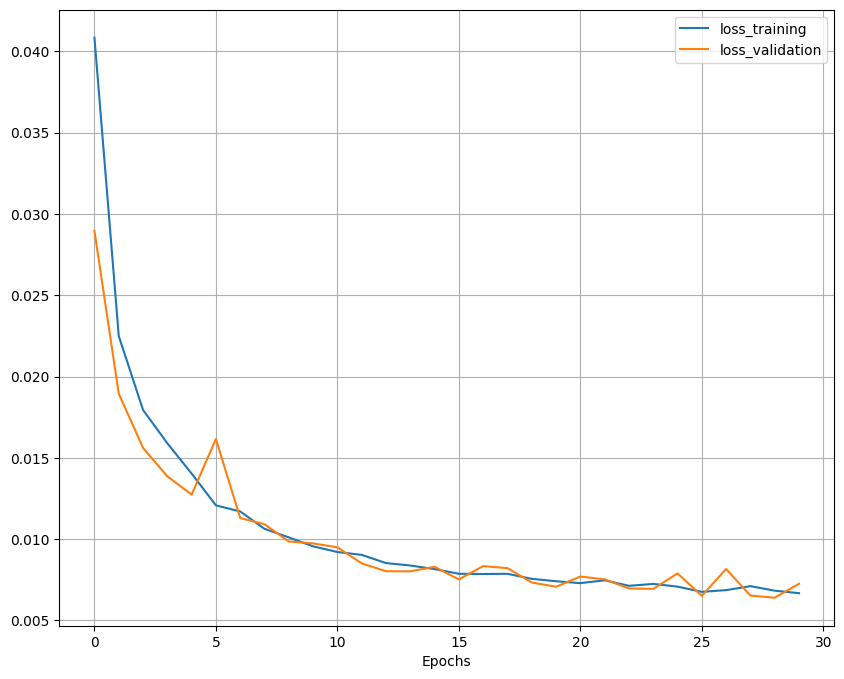

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(Shallow_non_AE)

Test Loss: 0.00723756


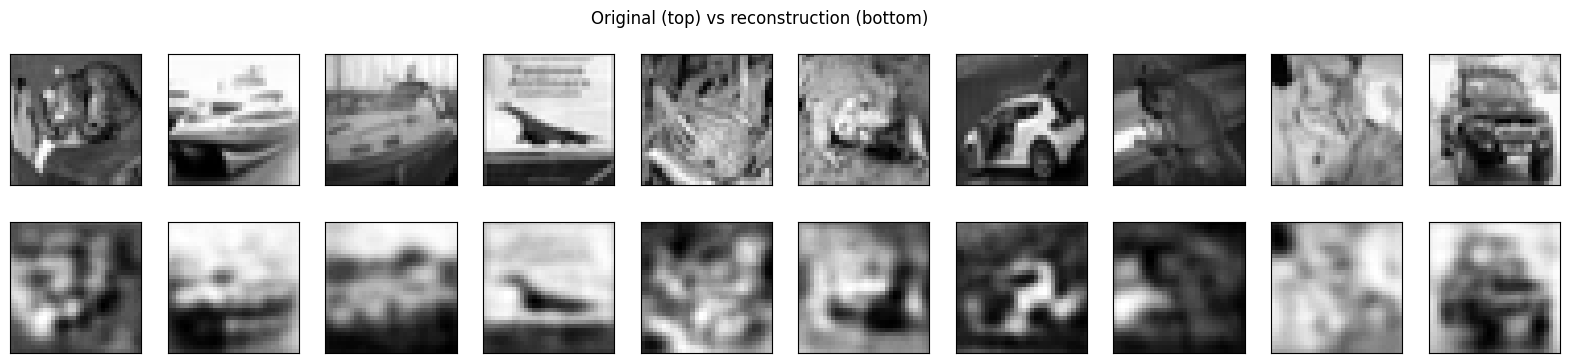

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

`%ENDCODE`

Discuss the results you obtained with the activation functions you have tested and also motivate your choice. Compare your results to the ones obtained with the Shallow Linear Autoencoder.

`%STARTEXT`

**ANSWER**:

Using the sigmoid function as activation function with the same learning rate set to 0.005 and the same number of training epochs (30) produces the smallest test loss (equals to 0.00724) among the other available non-linear activation functions (relu, leaky_relu, tanh). The sigmoid function usually does not obtain great results in deep autoencoder due to the vanishing gradient, but this shallow model is not characterized by this type of problem.

`%ENDTEXT`

# [TO COMPLETE] Deep Autoencoder

**[TO COMPLETE]**: Define a deep version of the Autoeancoder defined above. The autoencoder has to **use at least $5$ layers**. The model will use 𝑛 layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g. `IN_DIM` → $k$ → $k/2$, where $k/2$ is the arbitrarly chosen encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e., $k$ → `IN_DIM`, the resulting overall structure recalls an hourglass!). Try different hyperparameters configurations and write a short report of your experiments below. Leave the best execution in the code cells.

`%STARTCODE`

In [ ]:
# [TO COMPLETE]
# define model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [1024, 512, 256]
DEC_LAYERS = [512, 1024]
ACT_FUN = 'leaky_relu'
lr = 0.0005
epochs = 30  # Feel free to lower this to speed up the training times. Nevertheless, do not go below 25 epochs.
# END

DEEP_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(DEEP_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 1024]               1,049,600
│    └─Linear: 2-2                       [512, 512]                524,800
│    └─Linear: 2-3                       [512, 256]                131,328
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-4                       [512, 512]                131,584
│    └─Linear: 2-5                       [512, 1024]               525,312
│    └─Linear: 2-6                       [512, 1024]               1,049,600
Total params: 3,412,224
Trainable params: 3,412,224
Non-trainable params: 0
Total mult-adds (G): 1.75
Input size (MB): 2.10
Forward/backward pass size (MB): 17.83
Params size (MB): 13.65
Estimated Total Size (MB): 33.57

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DEEP_non_AE.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, loss_val = train(DEEP_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.07311989 ---------------- Val_Acc: Val_Loss: 0.04117926
epoch: 2 -> Loss: 0.03252337 ---------------- Val_Acc: Val_Loss: 0.02637007
epoch: 3 -> Loss: 0.02372557 ---------------- Val_Acc: Val_Loss: 0.02118618
epoch: 4 -> Loss: 0.01981338 ---------------- Val_Acc: Val_Loss: 0.01907362
epoch: 5 -> Loss: 0.01805159 ---------------- Val_Acc: Val_Loss: 0.01737276
epoch: 6 -> Loss: 0.01662493 ---------------- Val_Acc: Val_Loss: 0.01595903
epoch: 7 -> Loss: 0.01530878 ---------------- Val_Acc: Val_Loss: 0.01490851
epoch: 8 -> Loss: 0.01446169 ---------------- Val_Acc: Val_Loss: 0.01418857
epoch: 9 -> Loss: 0.01375555 ---------------- Val_Acc: Val_Loss: 0.01342478
epoch: 10 -> Loss: 0.01314681 ---------------- Val_Acc: Val_Loss: 0.01276524
epoch: 11 -> Loss: 0.01247017 ---------------- Val_Acc: Val_Loss: 0.01238256
epoch: 12 -> Loss: 0.01201873 ---------------- Val_Acc: Val_Loss: 0.01176847
epoch: 13 -> Loss: 0.01155380 ---------------- Val_Acc: Val_Loss: 0.01139153
epoch: 1

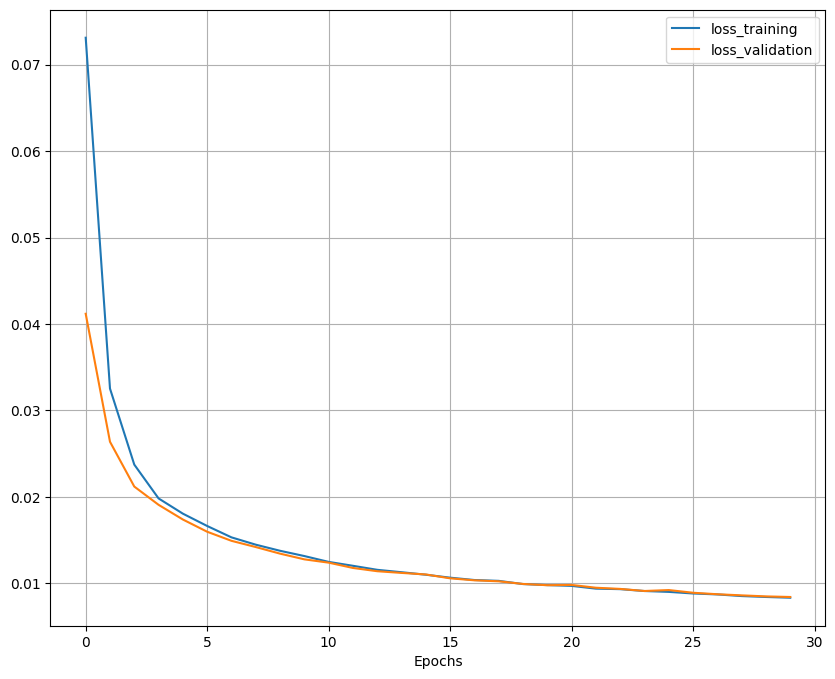

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(DEEP_non_AE)

Test Loss: 0.00837872


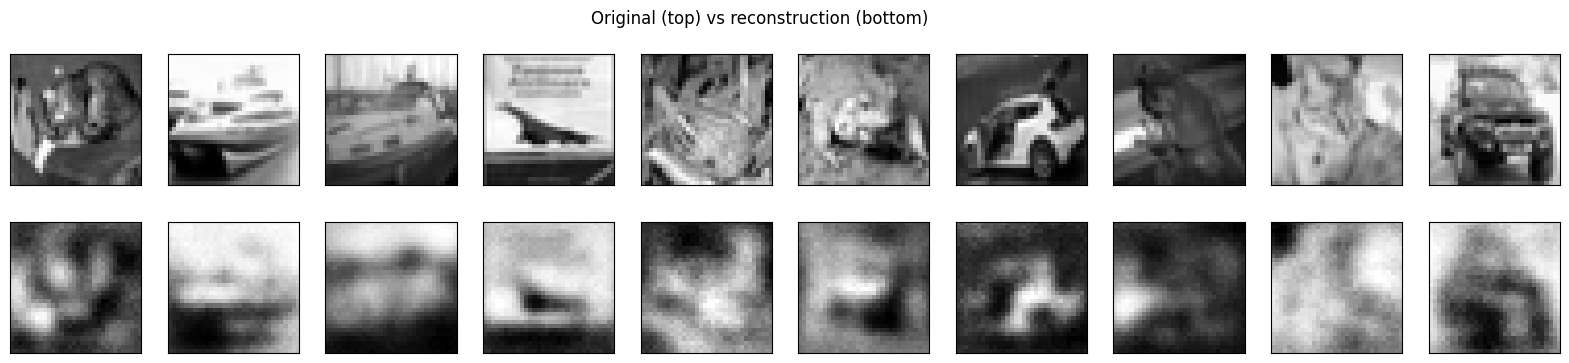

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=DEEP_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

`%ENDCODE`

Write a short report of the results you obtained trying different hyperparameters configurations.

`%STARTEXT`

**ANSWER**:

Using the best activation function of the shallow AE (sigmoid), results are not so good in this deep autoencoder using the architecture ENC_LAYERS = [512, 256, 128], DEC_LAYERS = [256, 512], maybe because of the vanishing gradient problem. With sigmoid as activation function, learning rate equals to 0.001 and epochs = 30, reconstructed images result very blurred without edges, with loss = 0.01943.
Also increasing the number of epochs to 50 or decreasin the learing rate, images remain very blurred and losses remain high (0.01769 for the former case, 0.1875 for the latter).

Changing the architecture to ENC_LAYERS = [1024, 512, 256], DEC_LAYERS = [512, 1024] and using the sigmoid activation function (with learning rate = 0.001, epochs = 30) loss value decreases (0.01115). Using the same architecture and changing the activation function, we obtain the following results:
- ACT_FUN = 'relu', lr = 0.001, epochs = 30,  loss = 0.02202
- ACT_FUN = 'tanh', lr = 0.001, epochs = 30,  loss = 0.01483
- ACT_FUN = 'leaky_relu', lr = 0.001, epochs = 30,  loss = 0.00859

leaky_relu seems to be the best activation function for this architecture. Trying to decrease the learning rate (lr = 0.0005), we obtain the best result for the model, with loss = 0.00838. Decreasing the learning rate to 0.00025, the loss value increases to 0.01004.

`%ENDTEXT`

# [TO COMPLETE] Shallow Denoising Autoencoder

**[TO COMPLETE]** Let's now use a shallow autoencoder to denoise the input data. We have defined a Dataloader able to return a noisy version of the input data. You can activate this capability by passing the parameter `denoising=True` to the `train` function.

Run some experiments with different hyperparameters values. You can also re-create the dataloaders at the beginning of the notebook and test what happens if you increase the noise level above $0.1$. Write a short report of your findings below.

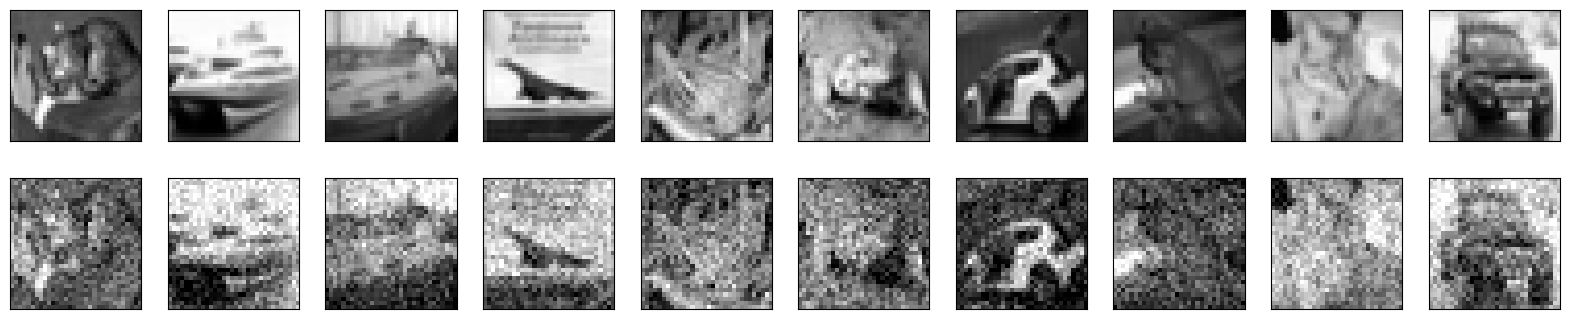

In [ ]:
plot_img(10, [x_test, x_test_noisy])

`%STARTCODE`

In [ ]:
# [TO COMPLETE]
# define model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256]
DEC_LAYERS = []
ACT_FUN = 'sigmoid'
lr = 0.001
epochs = 30 # Feel free to lower this to speed up the training times. Nevertheless, do not go below 25 epochs.
# END

SHALLOW_denoising_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(SHALLOW_denoising_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SHALLOW_denoising_AE.parameters(), lr=lr)

In [ ]:
start = timer()

# [TO COMPLETE]
# call the training function on noisy data
loss_train, loss_val = train(SHALLOW_denoising_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs, denoising= True)

end = timer()
print(f"Training time in second: {round(end - start)}")

epoch: 1 -> Loss: 0.04820324 ---------------- Val_Acc: Val_Loss: 0.03647468
epoch: 2 -> Loss: 0.02907840 ---------------- Val_Acc: Val_Loss: 0.02330628
epoch: 3 -> Loss: 0.02049180 ---------------- Val_Acc: Val_Loss: 0.01833768
epoch: 4 -> Loss: 0.01697823 ---------------- Val_Acc: Val_Loss: 0.01581224
epoch: 5 -> Loss: 0.01488789 ---------------- Val_Acc: Val_Loss: 0.01429593
epoch: 6 -> Loss: 0.01347145 ---------------- Val_Acc: Val_Loss: 0.01296528
epoch: 7 -> Loss: 0.01243330 ---------------- Val_Acc: Val_Loss: 0.01202037
epoch: 8 -> Loss: 0.01162340 ---------------- Val_Acc: Val_Loss: 0.01128844
epoch: 9 -> Loss: 0.01097498 ---------------- Val_Acc: Val_Loss: 0.01070191
epoch: 10 -> Loss: 0.01043000 ---------------- Val_Acc: Val_Loss: 0.01021321
epoch: 11 -> Loss: 0.01003572 ---------------- Val_Acc: Val_Loss: 0.00986907
epoch: 12 -> Loss: 0.00958269 ---------------- Val_Acc: Val_Loss: 0.00945533
epoch: 13 -> Loss: 0.00926265 ---------------- Val_Acc: Val_Loss: 0.00915095
epoch: 1

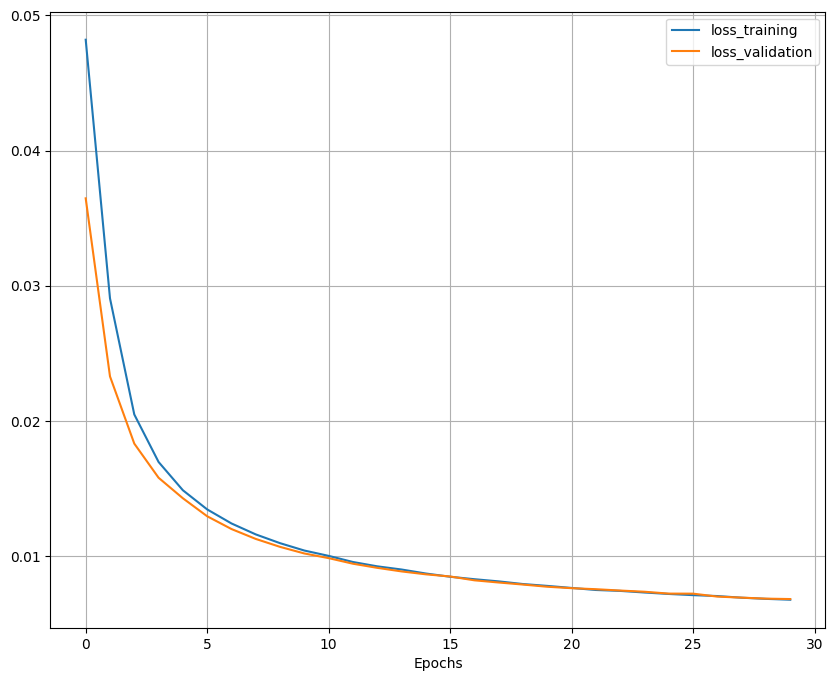

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(SHALLOW_denoising_AE, denoising=True)

Test Loss: 0.00682555


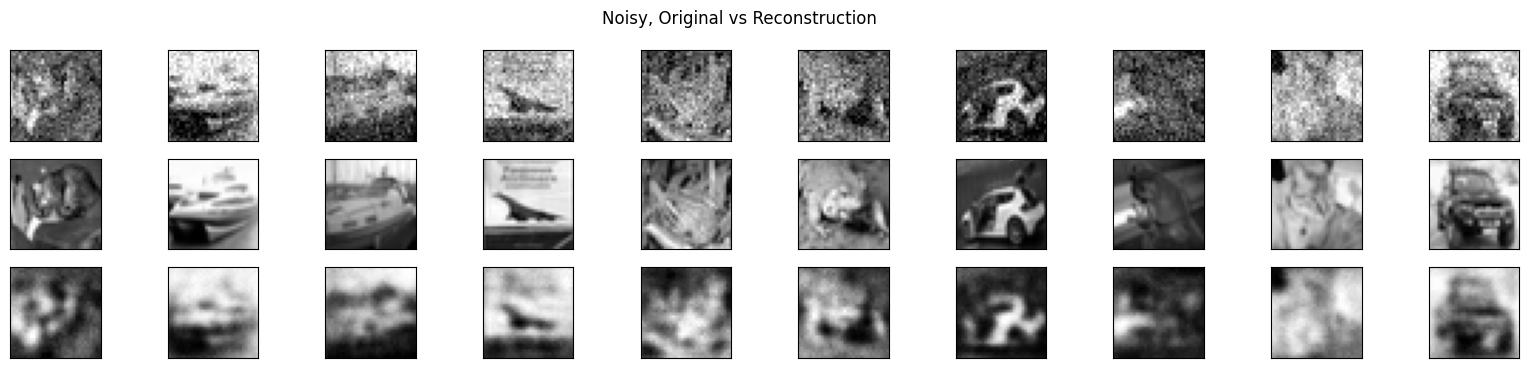

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=SHALLOW_denoising_AE, device=device, denoising=True)

plot_img(10, [x_test_noisy, x_test, decoded_imgs], title="Noisy, Original vs Reconstruction")

In [ ]:
# We now reduce the noise factor to 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512
noise_factor = 0.01 # adjust the noise level here.

dataloader_train_AE = DataLoader(CustomDataset(train_data, noise_factor, device), batch_size = batch_size)
dataloader_val_AE = DataLoader(CustomDataset(val_data, noise_factor, device), batch_size = batch_size)
dataloader_test_AE = DataLoader(CustomDataset(test_data, noise_factor, device), batch_size = batch_size)

In [ ]:
# [TO COMPLETE]
# define model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256]
DEC_LAYERS = []
ACT_FUN = 'sigmoid'
lr = 0.001
epochs = 30 # Feel free to lower this to speed up the training times. Nevertheless, do not go below 25 epochs.
# END

SHALLOW_denoising_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(SHALLOW_denoising_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SHALLOW_denoising_AE.parameters(), lr=lr)

In [ ]:
start = timer()

# [TO COMPLETE]
# call the training function on noisy data
loss_train, loss_val = train(SHALLOW_denoising_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs, denoising= True)

end = timer()
print(f"Training time in second: {round(end - start)}")

epoch: 1 -> Loss: 0.04857622 ---------------- Val_Acc: Val_Loss: 0.03618761
epoch: 2 -> Loss: 0.02870879 ---------------- Val_Acc: Val_Loss: 0.02308867
epoch: 3 -> Loss: 0.02017893 ---------------- Val_Acc: Val_Loss: 0.01793654
epoch: 4 -> Loss: 0.01644684 ---------------- Val_Acc: Val_Loss: 0.01532103
epoch: 5 -> Loss: 0.01422644 ---------------- Val_Acc: Val_Loss: 0.01345116
epoch: 6 -> Loss: 0.01276772 ---------------- Val_Acc: Val_Loss: 0.01222288
epoch: 7 -> Loss: 0.01165735 ---------------- Val_Acc: Val_Loss: 0.01119768
epoch: 8 -> Loss: 0.01078600 ---------------- Val_Acc: Val_Loss: 0.01050659
epoch: 9 -> Loss: 0.01007818 ---------------- Val_Acc: Val_Loss: 0.00987693
epoch: 10 -> Loss: 0.00949936 ---------------- Val_Acc: Val_Loss: 0.00931553
epoch: 11 -> Loss: 0.00900884 ---------------- Val_Acc: Val_Loss: 0.00887152
epoch: 12 -> Loss: 0.00857338 ---------------- Val_Acc: Val_Loss: 0.00847261
epoch: 13 -> Loss: 0.00821505 ---------------- Val_Acc: Val_Loss: 0.00810679
epoch: 1

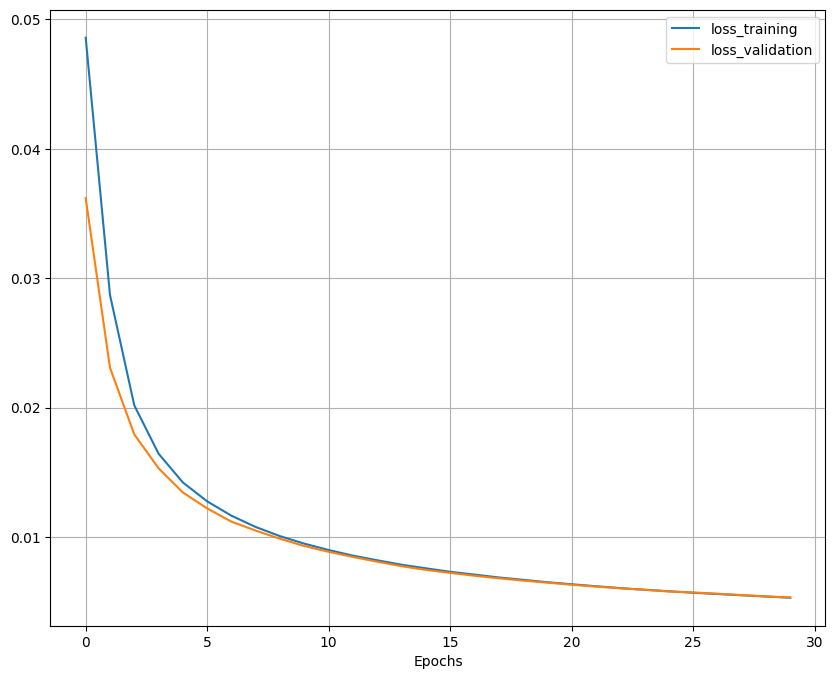

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(SHALLOW_denoising_AE, denoising=True)

Test Loss: 0.00733730


`%ENDCODE`

How strong is the impact of the noise factor on the model's denoising capability? What hyperparameter configuration worked for the noise levels you have tried?

`%STARTEXT`

**ANSWER**:

Using the shallow autoencoder with lr = 0.001 and ENC_LAYERS = [256], the best shallow autoencoder seems to be the best also for denoisying images. In fact, with noise = 0.1 and varying the activation function, we obtain the following loss values:
- ACT_FUN = 'linear', lr = 0.001, epochs = 30, loss = 0.00730
- ACT_FUN = 'leaky_relu', lr = 0.001, epochs = 30, loss = 0.01110
- ACT_FUN = 'sigmoid', lr = 0.001, epochs = 30, loss = 0.00683


Using the best denoising model (ACT_FUN = 'sigmoid', lr = 0.001, epochs = 30) and halfing the image noise to 0.05, the loss value decreases (0.00715) as the images become less noisy and more easy to correctly reconstruct. Decreasing the noise to 0.01, the loss value become again smaller (0.00734), as expected.


`%ENDTEXT`